In [1]:
import sys
sys.path.append("../")  

import numpy as np 
import torch, time
import matplotlib.pyplot as plt
import sys
import problem
import random
import net
from scipy.linalg import lstsq
torch.set_default_dtype(torch.float64)

def set_seed(seed=42):
    random.seed(seed)             # Python 内置随机数种子
    np.random.seed(seed)          # NumPy 随机数种子
    torch.manual_seed(seed)       # PyTorch CPU 随机数种子
    torch.cuda.manual_seed(seed)  # PyTorch GPU 随机数种子
    torch.cuda.manual_seed_all(seed)  # 多 GPU 训练时设定所有 GPU 相同种子
    torch.backends.cudnn.deterministic = True  # 保证 CUDA 计算的确定性
    torch.backends.cudnn.benchmark = False  # 关闭自动优化（可能影响速度）

# 设置随机种子
set_seed(42)

In [2]:
def trainnew(model,problem,device,params,optimizer):
    problem.generate_points(params["bodyBatch"], "random")
    int_data = problem.data()["interior_points"]
    bdry_data = problem.data()["boundary_points"]
    int_data.requires_grad = True
    bdry_data.requires_grad = True
    initialloss = 1
    model.train()
    entropys = []
    ranks = []
    for step in range(1, params["trainStep"]):
        u = model(int_data)[1]
        u = u.squeeze(1) if len(u.shape) == 2 else u
        u_second = model(int_data)[0]
        u_bdry = model(bdry_data)[1]
        u_bdry = u_bdry.squeeze(1) if len(u_bdry.shape) == 2 else u_bdry
        model.zero_grad()
        problem.loss_int(u, int_data)
        problem.loss_bdry(u, bdry_data)
        loss_pde = problem.loss_pde()
        loss_orthogonal = torch.norm(u_second.T @ u_second - torch.eye(params["width"]).to(device).double(), p='fro')
        loss = loss_pde + loss_orthogonal*params["orthogonalpenalty"]
        
        if step == 1:
            initialloss = loss_pde.detach().cpu().numpy()
        else:
            if loss_pde.detach().cpu().numpy()/initialloss < params["epsilon"]:
                print("Error at Step %s is %s"%(step+1,loss.detach().cpu().numpy()))
                break

        if step%params["writeStep"] == 0:
            print("Loss at Step %s is %s with pde loss %s, orthogonal loss %s."%(step,loss.detach().cpu().numpy(),loss_pde.detach().cpu().numpy(),loss_orthogonal.detach().cpu().numpy()))
            
        if step%params["plotStep"] == params["plotStep"]-1:
            pass
        
        if step%params["recordStep"] == 0:
            U, S, Vh = torch.linalg.svd(model(int_data)[0])
            S = S[S > params["effective_threshold"]]  
            p = S / S.sum()
            entropy = -(p * torch.log(p)).sum()
            entropys.append(entropy.detach().cpu().numpy())
            ranks.append(S.sum().detach().cpu().numpy())
        
        loss.backward()
        optimizer.step()
    (A, rhs) = problem.leastsquareproblem(model, int_data, bdry_data)
    w, residuals, rank, s = lstsq(A, rhs)
    error = A @ w - rhs
    effective_s = s[s > params["effective_threshold"]]
    effective_rank = (s > params["effective_threshold"]).sum()
    print("the error of least square in problem " + str(problem.name)+": ", np.mean(np.abs(error)))
    print("the condition number of matrix A in problem " + str(problem.name)+": ", np.max(effective_s)/np.min(effective_s))
    print("the rank of matrix A in problem " + str(problem.name)+": ", effective_rank)
    perdict = lambda x: torch.matmul(model(x)[0], torch.tensor(w).to(device))
    problem.plot(perdict)
    
    U, S, Vh = torch.linalg.svd(model(int_data)[0])
    
    return entropys, S, ranks

c:\Users\29433\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:769: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Loss at Step 50 is 139.86435374309698 with pde loss 2.0474434140810884, orthogonal loss 137.81691032901588.
Loss at Step 100 is 26.155134377021405 with pde loss 1.2892627559315581, orthogonal loss 24.86587162108985.
Loss at Step 150 is 15.909234240259046 with pde loss 0.7674610880474475, orthogonal loss 15.141773152211599.
the error of least square in problem poisson1d:  4.6544049861988805e-12
the condition number of matrix A in problem poisson1d:  4981939.826237295
the rank of matrix A in problem poisson1d:  24


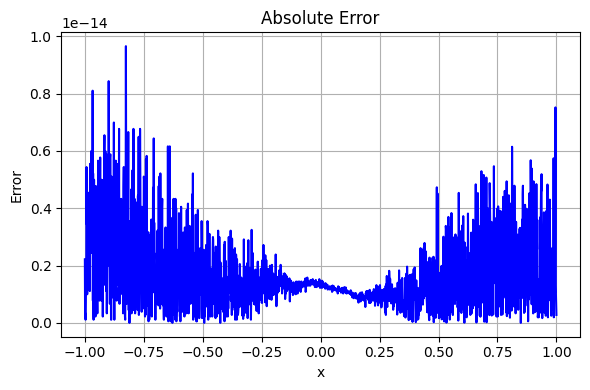

In [3]:
def u_exact(x):
    return -1/20*x**5 + 1/6*x**4 - 1/6*x**3 - 1/4*x + 3/20

def f(x):
    return x**3 - 2*x**2 + x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)


params = {"d": 1, "bodyBatch": 1000, "bdryBatch":2, "lr": 0.001, "width": 100, "depth":2, "trainStep": 200, "writeStep": 50, "plotStep": 100, "recordStep": 10, "decay": 0.0001, "epsilon": 1e-6, "orthogonalpenalty": 1, "effective_threshold":1e-3}
startTime = time.time()

model = net.PD_OFM(params).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
entropys_orthogonal, S_orthogonal, ranks_orthogonal = trainnew(model,Pro,device,params,optimizer)


        

Loss at Step 50 is 0.28073800453247744 with pde loss 0.28073800453247744, orthogonal loss 873.1681825961639.
Loss at Step 100 is 0.22247808606956945 with pde loss 0.22247808606956945, orthogonal loss 855.5683893994116.
Loss at Step 150 is 0.2219241747796951 with pde loss 0.2219241747796951, orthogonal loss 837.316157313423.
the error of least square in problem poisson1d:  3.8635076775886305e-11
the condition number of matrix A in problem poisson1d:  5235769.575097822
the rank of matrix A in problem poisson1d:  17


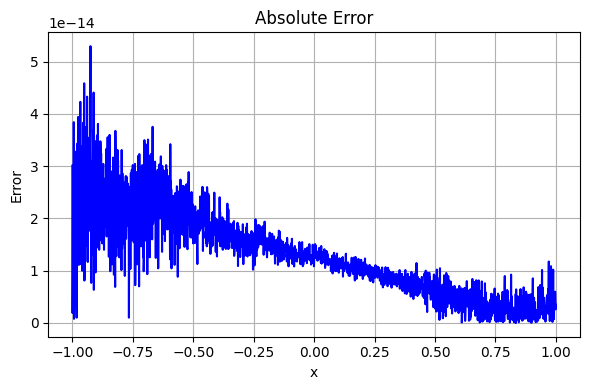

In [4]:
def u_exact(x):
    return -1/20*x**5 + 1/6*x**4 - 1/6*x**3 - 1/4*x + 3/20

def f(x):
    return x**3 - 2*x**2 + x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
Pro = problem.Poisson1D(f, u_exact, u_exact, 1)

params = {"d": 1, "bodyBatch": 1000, "bdryBatch":2, "lr": 0.001, "width": 100, "depth":2, "trainStep": 200, "writeStep": 50, "plotStep": 100, "recordStep":10, "decay": 0.0001, "epsilon": 1e-6, "orthogonalpenalty": 0, "effective_threshold":1e-3}
startTime = time.time()

model = net.PD_OFM(params).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
entropy_baseline, S_baseline, ranks_baseline = trainnew(model,Pro,device,params,optimizer)


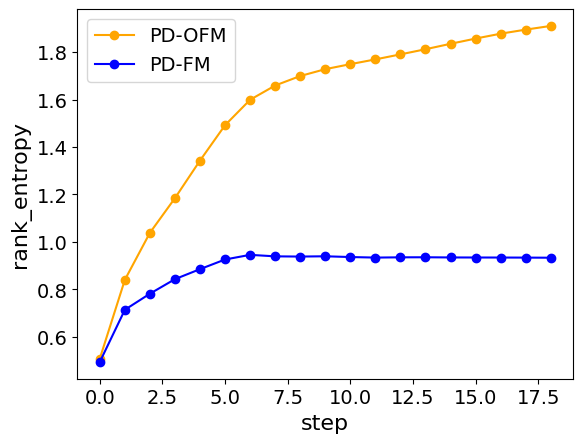

Effective ranks with respect to different thresholds in PD-OFM:     [32 29 28 25 24 22 20 17 15 13 10  8  6  0  0]
Effective ranks with respect to different thresholds in PD-FM:  [22 21 19 18 16 15 13 11 10  8  7  5  4  2  0]


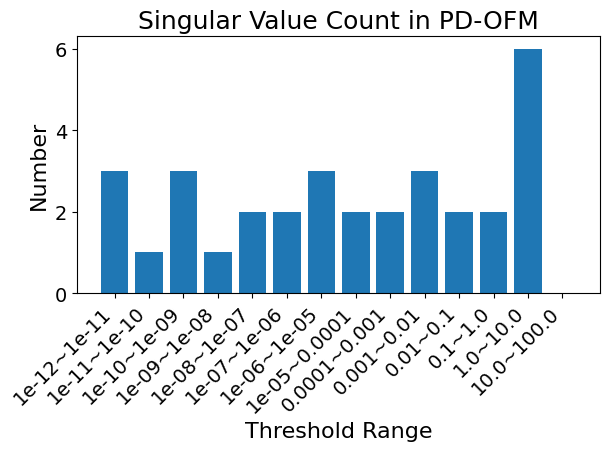

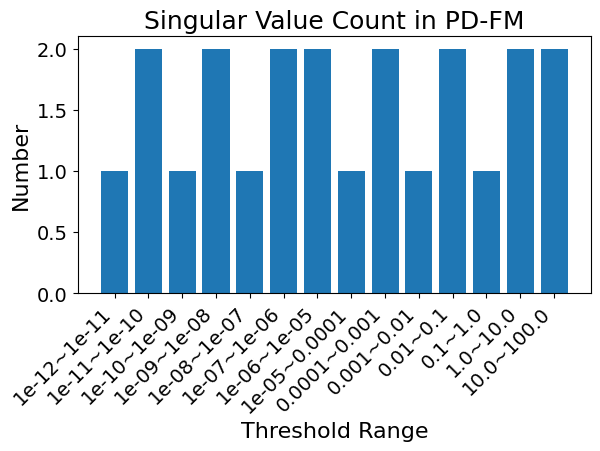

In [5]:
plt.rcParams.update({
    'font.size': 16,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'legend.fontsize': 14
})

t1 = np.arange(len(entropys_orthogonal))
t2 = np.arange(len(entropy_baseline))
plt.plot(t1, entropys_orthogonal, marker="o", label="PD-OFM", color='orange')
plt.plot(t2, entropy_baseline, marker="o", label="PD-FM", color='blue')
plt.xlabel("step")
plt.ylabel("rank_entropy")
plt.legend()
plt.show()

thresholds = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2]
effective_ranks_org = []
effective_ranks_baseline = []

for threshold in thresholds:
    rank_org = (S_orthogonal > threshold).sum()
    rank_baseline = (S_baseline > threshold).sum()
    effective_ranks_org.append(rank_org.item())
    effective_ranks_baseline.append(rank_baseline.item())

ranks_np_org = np.array(effective_ranks_org)
ranks_np_baseline = np.array(effective_ranks_baseline)
delta_ranks_org = -np.diff(ranks_np_org)  
delta_ranks_baseline = -np.diff(ranks_np_baseline)  
print("Effective ranks with respect to different thresholds in PD-OFM:    ", ranks_np_org)
print("Effective ranks with respect to different thresholds in PD-FM: ", ranks_np_baseline)


plt.figure()
plt.bar(range(len(delta_ranks_org)), delta_ranks_org, tick_label=[f"{thresholds[i]}~{thresholds[i+1]}" for i in range(len(delta_ranks_org))])
plt.xticks(rotation=45)
plt.title("Singular Value Count in PD-OFM")
plt.xlabel("Threshold Range")
plt.ylabel("Number")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()


plt.figure()
plt.bar(range(len(delta_ranks_baseline)), delta_ranks_baseline, tick_label=[f"{thresholds[i]}~{thresholds[i+1]}" for i in range(len(delta_ranks_org))])
plt.xticks(rotation=45)
plt.title("Singular Value Count in PD-FM")
plt.xlabel("Threshold Range")
plt.ylabel("Number")
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

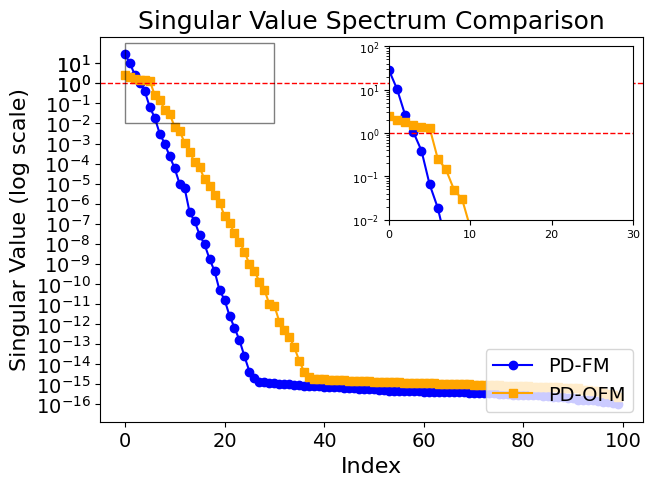

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# 假设已有奇异值
s1 = S_baseline.detach().cpu().numpy()
s2 = S_orthogonal.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(7,5))

# 主图
ax.semilogy(s1, 'o-', label='PD-FM', color='blue')
ax.semilogy(s2, 's-', label='PD-OFM', color='orange')
ax.set_xlabel('Index')
ax.set_ylabel('Singular Value (log scale)')
ax.set_title('Singular Value Spectrum Comparison')
ax.legend(loc="lower right")  

# 设置更密刻度
yticks = [10**k for k in range(-16, 2)] + [1, 10]
ax.set_yticks(yticks)

# 横线 y=1
ax.axhline(y=1, color='red', linestyle='--', linewidth=1)

# ----------------
# inset 放大图
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="45%", height="45%", loc="upper right")
axins.semilogy(s1, 'o-', label='PD-FM', color='blue')
axins.semilogy(s2, 's-', label='PD-OFM', color='orange')
axins.axhline(y=1, color='red', linestyle='--', linewidth=1)

# 只看前30个奇异值
axins.set_xlim(0, 30)
axins.set_ylim(1e-2, 1e2)   # 你可以根据数据调整范围
axins.set_xticks([0,10,20,30])
axins.set_yticks([1e-2, 1e-1, 1, 10, 100])
axins.tick_params(labelsize=8)

ax.indicate_inset_zoom(axins, edgecolor="black")
# ----------------

plt.show()
